In [191]:
import os
import csv
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [204]:
from collections import defaultdict
from tqdm.notebook import tqdm
from numpy import linalg
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [23]:
MODELS_DIR = 'models'
HISTOGRAMS_DIR = 'histograms'
LABELS_FILE = 'labels.csv'

## Building a dataset

In the following section, I match generated models with histograms and build a dataset for further analysis. However, its' content isn't essential for the home assignment evaluation (i.e., it does not contain anything related to the clustering).

In [14]:
def list_directory(directory_name):
    return [filename.split('.')[0] for filename in os.listdir(directory_name)]

def load_models_names():
    return list_directory(MODELS_DIR)

def load_histogram_names():
    return list_directory(HISTOGRAMS_DIR)

In [157]:
models = load_models_names()
histograms = set(load_histogram_names())
models_with_histograms = [model for model in models if model in histograms]

In [158]:
def generate_dataset(target_size=1000):
    models = np.random.choice(models_with_histograms, target_size, replace=False)
    labels = pd.read_csv(LABELS_FILE)
    shape_dict = {}
    for _, row in labels.iterrows():
        shape_dict[row['model']] = row['type']
    data = defaultdict(lambda: [])
    for model in tqdm(models):
        data['model'].append(model)
        data['type'].append(shape_dict[model])
        with open(os.path.join(HISTOGRAMS_DIR, f'{model}.json'), 'r') as json_file:
            json_data = json.load(json_file)
            for hist in json_data['histogram_data']:
                hist_intervals = hist['intervals']
                for i in range(hist_intervals):
                    hist_type = hist['type']
                    data[f'{hist_type}_{hist_intervals}_{i}'].append(hist['data'][i])
    return pd.DataFrame(data)

In [159]:
data = generate_dataset()

In [160]:
data.head()

,model,type,model_bounding_sphere_strict_outer_8_0,model_bounding_sphere_strict_outer_8_1,model_bounding_sphere_strict_outer_8_2,model_bounding_sphere_strict_outer_8_3,model_bounding_sphere_strict_outer_8_4,model_bounding_sphere_strict_outer_8_5,model_bounding_sphere_strict_outer_8_6,model_bounding_sphere_strict_outer_8_7,...,hull_bounding_sphere_concentric_sphere_128_118,hull_bounding_sphere_concentric_sphere_128_119,hull_bounding_sphere_concentric_sphere_128_120,hull_bounding_sphere_concentric_sphere_128_121,hull_bounding_sphere_concentric_sphere_128_122,hull_bounding_sphere_concentric_sphere_128_123,hull_bounding_sphere_concentric_sphere_128_124,hull_bounding_sphere_concentric_sphere_128_125,hull_bounding_sphere_concentric_sphere_128_126,hull_bounding_sphere_concentric_sphere_128_127
0,0c38ffa0-fd81-4de5-bf4c-417175347d79,Cube,0.035817,0.147870,0.229957,0.310040,0.196538,0.066685,0.012622,0.000471,...,0.003851,0.003540,0.003274,0.003019,0.002712,0.002521,0.002220,0.001979,0.001716,0.001449
1,19c27722-8c46-4104-8b50-7b26675c7ece,Sphere,0.029370,0.098072,0.219350,0.423980,0.187379,0.036324,0.005446,0.000079,...,0.004043,0.003918,0.003580,0.003308,0.003024,0.002801,0.002564,0.002298,0.001460,0.000437
2,1e86ba09-b6b7-498d-8c36-1e20c97c706e,Sphere,0.036141,0.108582,0.229274,0.474540,0.125983,0.023164,0.002305,0.000010,...,0.004199,0.003935,0.003646,0.003420,0.003076,0.002943,0.002743,0.002606,0.001666,0.000541
3,0fcf0b8b-9f75-4991-8f4e-9e73335dcf63,Torus.1464,0.077156,0.145163,0.264993,0.296588,0.165992,0.044896,0.005213,0.000000,...,0.005782,0.005646,0.005339,0.005077,0.004950,0.004923,0.005313,0.004977,0.003463,0.001326
4,21301d27-2ffb-4b90-b2ed-89bc02212053,Cube,0.047612,0.169614,0.240002,0.295299,0.173891,0.061158,0.012127,0.000297,...,0.006607,0.006354,0.005992,0.005370,0.004814,0.004535,0.004066,0.003191,0.002522,0.000628


In [161]:
data.to_csv('data.csv', index=False)

Perform cleanup for space economy purposes

In [105]:
models = set(data['model'])
for filename in os.listdir(MODELS_DIR):
    if filename.split('.')[0] not in models:
        os.remove(os.path.join(MODELS_DIR, filename))
for filename in os.listdir(HISTOGRAMS_DIR):
    if filename.split('.')[0] not in models:
        os.remove(os.path.join(HISTOGRAMS_DIR, filename))
labels = pd.read_csv(LABELS_FILE)
labels['selected'] = labels['model'].apply(lambda model: model in models)
labels = labels.drop(labels[labels.selected == False].index)
labels = labels.drop(columns=['selected'])
labels.to_csv('labels.csv', index=False)

## Analisys

Baseline idea:
* For each histogram type, apply DBSCAN / AgglomerativeClustering on all the models using L1 and L2 norms;
* Cluster the models based on the clustering results for individual histograms.

In [110]:
histogram_types = set(['_'.join(column.split('_')[:-1]) for column in data.columns if column not in {'model',
                                                                                                     'type'}])
histogram_types

{'hull_bounding_sphere_concentric_sphere_128',
 'hull_bounding_sphere_concentric_sphere_16',
 'hull_bounding_sphere_concentric_sphere_32',
 'hull_bounding_sphere_concentric_sphere_64',
 'hull_bounding_sphere_concentric_sphere_8',
 'hull_bounding_sphere_missed_128',
 'hull_bounding_sphere_missed_16',
 'hull_bounding_sphere_missed_32',
 'hull_bounding_sphere_missed_64',
 'hull_bounding_sphere_missed_8',
 'hull_bounding_sphere_strict_outer_128',
 'hull_bounding_sphere_strict_outer_16',
 'hull_bounding_sphere_strict_outer_32',
 'hull_bounding_sphere_strict_outer_64',
 'hull_bounding_sphere_strict_outer_8',
 'hull_bounding_sphere_strict_outer_absolute_128',
 'hull_bounding_sphere_strict_outer_absolute_16',
 'hull_bounding_sphere_strict_outer_absolute_32',
 'hull_bounding_sphere_strict_outer_absolute_64',
 'hull_bounding_sphere_strict_outer_absolute_8',
 'model_bounding_sphere_concentric_sphere_128',
 'model_bounding_sphere_concentric_sphere_16',
 'model_bounding_sphere_concentric_sphere_32'

In [162]:
def get_histogram(histogram_name):
    size = int(histogram_name.split('_')[-1])
    return data[[f'{histogram_name}_{i}' for i in range(size)]].to_numpy()

In [163]:
def distance(x, y):
    l1 = linalg.norm(x - y, ord=1) / (x.sum() + y.sum())
    l2 = linalg.norm(x - y, ord=2) / ((x**2 + y**2).sum()**0.5)
    return (l1 + l2) / 2

In [176]:
eps = 1e-5

clusters = {} 
for histogram_type in tqdm(histogram_types):
    clusters[f'DBSCAN_{histogram_type}'] = DBSCAN(metric=distance, eps=0.00001).fit(
        get_histogram(histogram_type)).labels_
clusters_df = pd.DataFrame(clusters)

In [179]:
clusters_df.corr()

,DBSCAN_hull_bounding_sphere_concentric_sphere_64,DBSCAN_model_bounding_sphere_strict_outer_absolute_8,DBSCAN_model_bounding_sphere_missed_16,DBSCAN_model_bounding_sphere_strict_outer_128,DBSCAN_model_bounding_sphere_strict_outer_absolute_32,DBSCAN_model_bounding_sphere_strict_outer_absolute_64,DBSCAN_model_bounding_sphere_strict_outer_16,DBSCAN_model_bounding_sphere_concentric_sphere_64,DBSCAN_hull_bounding_sphere_strict_outer_8,DBSCAN_hull_bounding_sphere_strict_outer_absolute_16,...,DBSCAN_hull_bounding_sphere_concentric_sphere_32,DBSCAN_hull_bounding_sphere_concentric_sphere_128,DBSCAN_hull_bounding_sphere_strict_outer_16,DBSCAN_model_bounding_sphere_missed_64,DBSCAN_model_bounding_sphere_concentric_sphere_8,DBSCAN_model_bounding_sphere_strict_outer_32,DBSCAN_hull_bounding_sphere_missed_64,DBSCAN_model_bounding_sphere_concentric_sphere_16,DBSCAN_hull_bounding_sphere_strict_outer_absolute_128,DBSCAN_hull_bounding_sphere_missed_8
DBSCAN_hull_bounding_sphere_concentric_sphere_64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_strict_outer_absolute_8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_missed_16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_strict_outer_128,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_strict_outer_absolute_32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_strict_outer_absolute_64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_strict_outer_16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_model_bounding_sphere_concentric_sphere_64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_hull_bounding_sphere_strict_outer_8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DBSCAN_hull_bounding_sphere_strict_outer_absolute_16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We can see that different histogram types produce the same cluster set. One possible explanation for it -- lack of hyperparameters tuning (such for instance,  ε)

Therefore, I suggest to extend this information with other clustering approches:

In [182]:
clusters_df_backup = clusters_df.copy()

In [185]:
for histogram_type in tqdm(histogram_types):
    for n_clusters in range(2, 6):
        hist = get_histogram(histogram_type)
        clusters_df[f'AgglomerativeClustering_{histogram_type}_{n_clusters}'] = AgglomerativeClustering(n_clusters=n_clusters).fit(hist).labels_
        clusters_df[f'KMeans_{histogram_type}_{n_clusters}'] = KMeans(n_clusters=n_clusters).fit(hist).labels_

Let's visualize the obtained results via PCA:

Now let's apply clustering on the top of different clustering results :)

In [187]:
result_clusters = {}
for n_clusters in tqdm(range(2, 10)):
    result_clusters[n_clusters] = KMeans(n_clusters=n_clusters).fit(clusters_df.to_numpy()).labels_

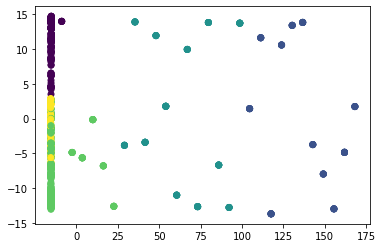

In [202]:
X = PCA(n_components=2).fit_transform(clusters_df)

plt.scatter(X[:, 0], X[:, 1], c=result_clusters[5])
plt.show()

Now let's compare the obtained clustering results with the figure types:

In [203]:
labels['shape'] = labels['type'].apply(lambda t: t.split('.')[0])
labels.head()

,model,type,shape
7,1b220e0b-d7fa-40a0-8cfd-930a3228c668,Sphere,Sphere
17,1346fe51-b6f1-4036-a2c4-cdf84abf6c85,Cone,Cone
24,0b75c9af-3446-4610-973c-f81ad11f660a,Cone,Cone
33,13f0e1de-9b77-429b-b2cf-62b9a7dfb2d5,Sphere,Sphere
58,139926b6-ca10-4f77-956c-5d023a3b5ce1,Cone,Cone
